In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Deterministic Solution

In [3]:
x = np.linspace(0,3000,100) # nm
Ermes_radius = 150 # nm
Dump_radius = 250 # nm
Num_ermes = [1,2,3,4,5,6] # count
Cell_radius = 3000 # nm

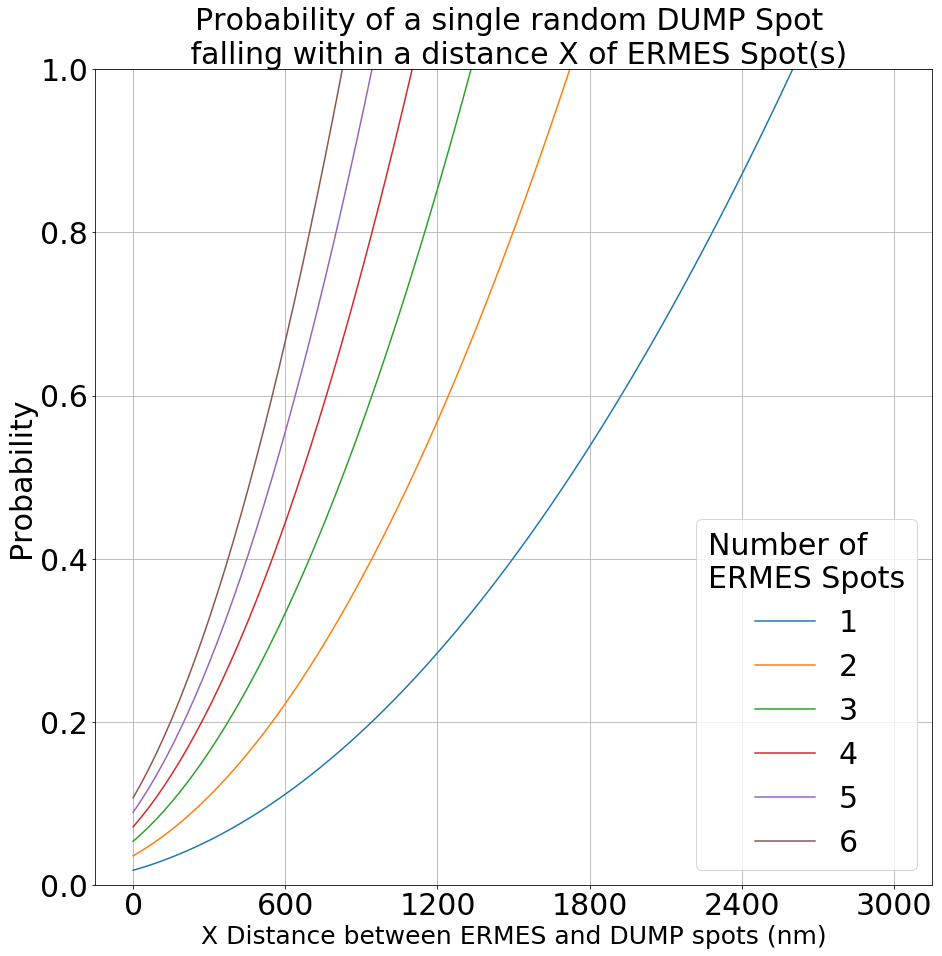

In [4]:
plt.figure(figsize=(15,15))
for n in Num_ermes:
    prob = (n * (x + Ermes_radius + Dump_radius)**2)/(Cell_radius**2)
    plt.plot(x,prob, label = n)
    plt.ylim([0,1])
    
legend = plt.legend(title="Number of \nERMES Spots",
                    loc=4, fontsize=30, fancybox=True)
plt.setp(legend.get_title(),fontsize=30)
plt.xlabel('X Distance between ERMES and DUMP spots (nm)', fontsize = 25)
plt.ylabel('Probability', fontsize = 30)
plt.title('Probability of a single random DUMP Spot \n falling within a distance X of ERMES Spot(s)', fontsize = 30)
plt.yticks(ticks = np.linspace(0,1,6),fontsize = 30)
plt.xticks(ticks = np.linspace(0,3000,6),fontsize = 30)

plt.grid()
plt.savefig('myfig.eps', format='eps')

# Stochastic Simulation Setup

In [5]:
Ermes_radius = 150 # nm
Dump_radius = 250 # nm
Num_ermes = [1,2,3,4,5,6] # count
Cell_radius = 3000 # nm

def dist(pt1, pt2):
    '''Calculate euclidian distance between two coordinates provided in numpy vector format.
    Parameters
    ==========
    pt1, pt2 (np.ndarray) : coordinate of the target to be queried.
    Returns
    ==========
    (float) Euclidian distance between supplied points.
    '''
    return np.sqrt(np.sum((pt1-pt2)**2))


def generateLandscape(numTargets, targetRadius, maxRadius, permitOverlap = False, dimension = 2):
    '''Given a number of targets, each target's radius, and the maximum radius in which they are 
    allowed to be generated within, return a list of circle centers of len numTargets that are within 
    the maxRadius and either overlap or not (permitOverlap)
    Parameters
    ==========
    numTargets (int) : number of targets to generate
    targetRadius (float) : radius of target to generate 
    maxRadius (float) : maximum radius boundary for target space.
    permitOverlap (bool) : are circles/spheres permitted to overlap in space (True for yes overlap)
    dimension (int) : dimensions to simulate space in
    Returns
    ==========
    (list) of (np.ndarray) List of target center coordinates.
    '''
    
    targetPts = []
    origin = np.zeros(dimension)
    def checkCollision(queryTarget):
        '''Check to see if a newly generated target's perimeter falls outside of the 
        maximum radius or falls within the radius of other targets. Inherits the permitOverlap
        condition.
        Parameters
        ==========
        queryTarget (np.ndarray) : coordinate of the target to be queried.
        Returns
        ==========
        (bool) True if there is a collision detected.
        '''
        if dist(queryTarget, origin) >= (maxRadius - targetRadius):
            return True
        else:
            if permitOverlap:
                return False
            else:
                for pt in targetPts:
                    if dist(queryTarget, pt) <= (targetRadius * 2):
                        return True
                return False
            
    # Continuously generate target points until desired number is fulfilled.
    while len(targetPts) < numTargets:
        
        candidateTarget = np.random.uniform(low=-maxRadius, high=maxRadius, size=(dimension,))
        if checkCollision(candidateTarget):
            continue
        else:
            targetPts.append(candidateTarget)
    targetPts = np.array(targetPts)
    return targetPts


def plotLandscape(targetList, targetRadius, maxRadius, show = False, figsize = (10,10)):
    '''Visualization module for 2D or 3D target visualization
    Parameters
    ==========
    targetList (np.ndarray) : array with cartesian coordinates for the center of each target
    targetRadius (float) : target radius
    maxRadius (float) : maximum radius of target
    show (bool) : whether to show the image or not.
    figsize (tuple) : size of the resulting figure in inches.
    
    Returns:
    ==========
    figure/axes object
    '''
    def plot2DLandscape():
        fig, ax = plt.subplots(figsize = figsize)
        ax.set(xlim=(-maxRadius, maxRadius), ylim = (-maxRadius, maxRadius))

        a_circle = plt.Circle((0,0), maxRadius, alpha = 0.1, color = 'b')
        ax.add_artist(a_circle)
        for target in targetList:
            a_circle = plt.Circle(target, targetRadius, alpha = 0.5, color = 'r')
            ax.add_artist(a_circle)
        if show == True: 
            plt.show()
        else:
            return fig, ax

    def plot3DLandscape():
        fig = plt.figure(figsize = figsize)
        ax = fig.add_subplot(111, projection='3d')
        # Generate outer sphere
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = maxRadius * np.outer(np.cos(u), np.sin(v))
        y = maxRadius * np.outer(np.sin(u), np.sin(v))
        z = maxRadius * np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_surface(x, y, z, color='b', alpha = 0.075)
        # Generate each of the target spheres
        x_target = targetRadius * np.outer(np.cos(u), np.sin(v))
        y_target = targetRadius * np.outer(np.sin(u), np.sin(v))
        z_target = targetRadius * np.outer(np.ones(np.size(u)), np.cos(v))
        for target in targetList:
            ax.plot_surface(x_target + target[0], 
                            y_target+ target[1], 
                            z_target+ target[2], color='r', alpha = 0.2)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        if show:
            plt.show()
        else:
            return fig, ax  
        
    if targetList.shape[-1] == 2:
        return plot2DLandscape()
    elif targetList.shape[-1] == 3:
        return plot3DLandscape()
    else:
        raise Exception("Unexpected number of dimensions in targetlist")    
    
    
def genDart(targetRadius, maxRadius, dimension = 2):
    '''Generates a random dart of radius targetRadius within a maxRadius of dimension dimension.
    Parameters
    ==========
    targetRadius (float) : size of the dart's radius
    maxRadius (float) : size of the arena the dart is permitted to hit
    dimension (int) : target dimension shape
    Returns
    ==========
    (np.ndarray) coordinates for generated dart.
    '''
    while True:
        dartLocation = np.random.uniform(low=-maxRadius, high=maxRadius, size=(dimension,))
        if dist(dartLocation, np.zeros(dimension)) >= (maxRadius - targetRadius):
            continue
        else:
            return dartLocation    
        

# Actual Simulation part

In [8]:
DIMENSION = 3
NUMTARGETS = np.array([1,2,4,8,16,32])#np.arange(1,10)
TARGETRAD = 0.15 #um
DARTRAD = 0.25 #um
MAXRAD = 3 #um
PERMITOVERLAP = False
N_SIMS = 203#10000

output = []
for nTargets in NUMTARGETS:
    for simNum in range(N_SIMS):
        targets = generateLandscape(numTargets = nTargets, 
                                    targetRadius = TARGETRAD, 
                                    maxRadius = MAXRAD, 
                                    permitOverlap = PERMITOVERLAP, 
                                    dimension = DIMENSION)

        DART = genDart(targetRadius = TARGETRAD, 
                       maxRadius = MAXRAD, 
                       dimension = DIMENSION)

        DIST_MATRIX = [dist(DART, subTarget) - TARGETRAD - DARTRAD for subTarget in targets]
        # Record only the minimum distance between the dart and any given target.
        output.append([simNum, nTargets, np.min(DIST_MATRIX)])
filename = f'QQ_output_dim{DIMENSION}.csv'
dataset = pd.DataFrame(output)
dataset.to_csv(filename, index=False, header=False)



# Plot Block used for generating sample image of what the target space should look like
# fig, ax = plotLandscape(targets, targetRadius=TARGETRAD, maxRadius=MAXRAD, show = False)
# if DIMENSION == 2:
#     a_circle = plt.Circle(DART, DARTRAD, alpha = 0.1, color = 'b')
#     ax.add_artist(a_circle)
#     plt.savefig('2dMODEL.png', format='png')
# elif DIMENSION == 3:
#     u = np.linspace(0, 2 * np.pi, 100)
#     v = np.linspace(0, np.pi, 100)
#     x = DARTRAD * np.outer(np.cos(u), np.sin(v))
#     y = DARTRAD * np.outer(np.sin(u), np.sin(v))
#     z = DARTRAD * np.outer(np.ones(np.size(u)), np.cos(v))
#     ax.plot_surface(x + DART[0], y + DART[1], z + DART[2], color='b', alpha = 0.5)
#     # ax.view_init(30, 90)
#     plt.savefig('3dMODEL.png', format='png')

# Plot dataset per simulation

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


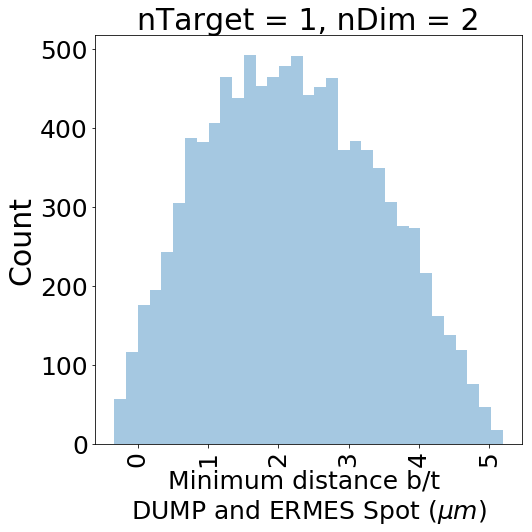

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


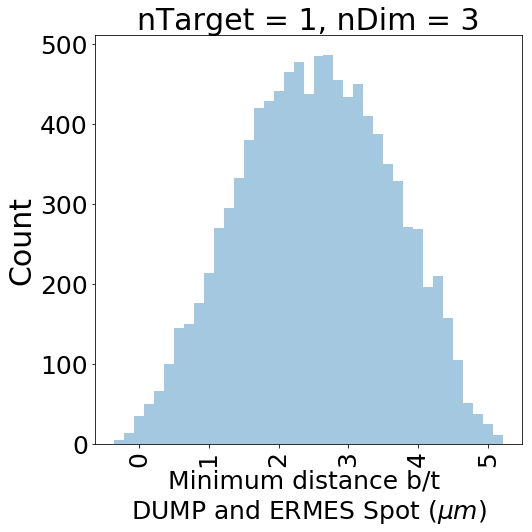

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


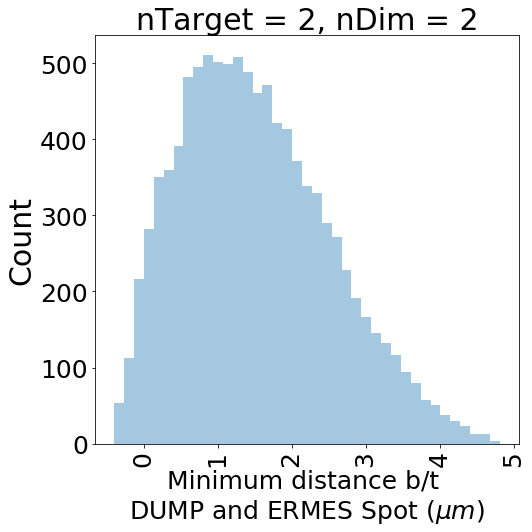

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


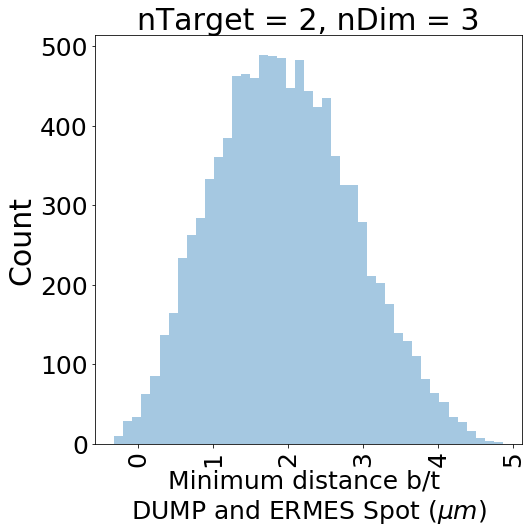

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


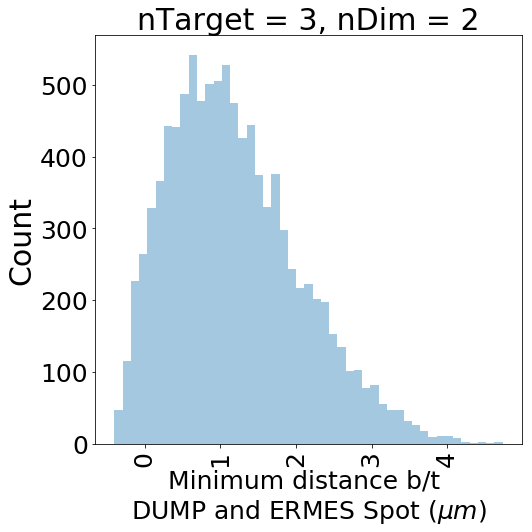

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


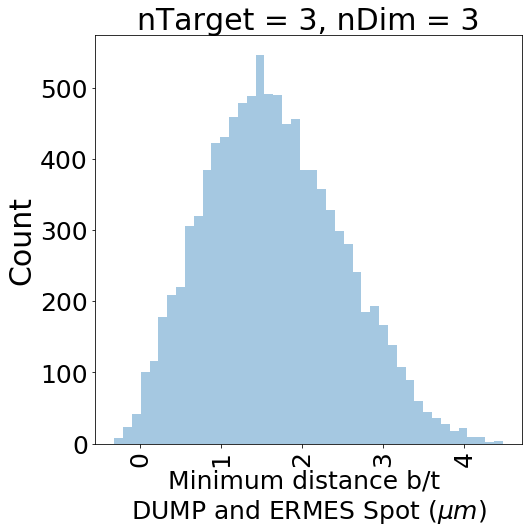

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


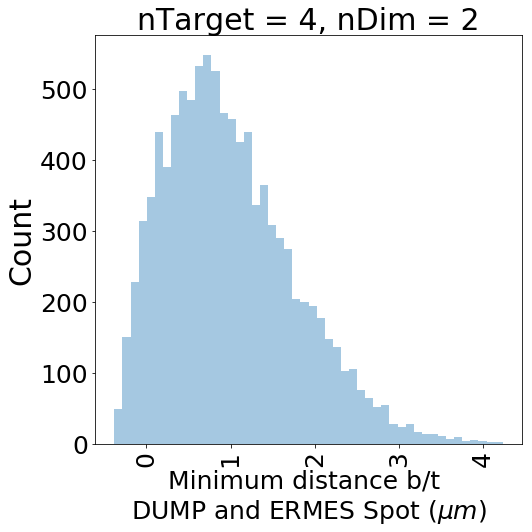

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


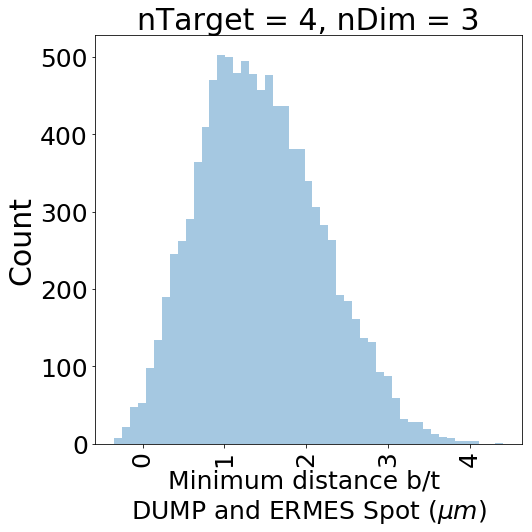

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


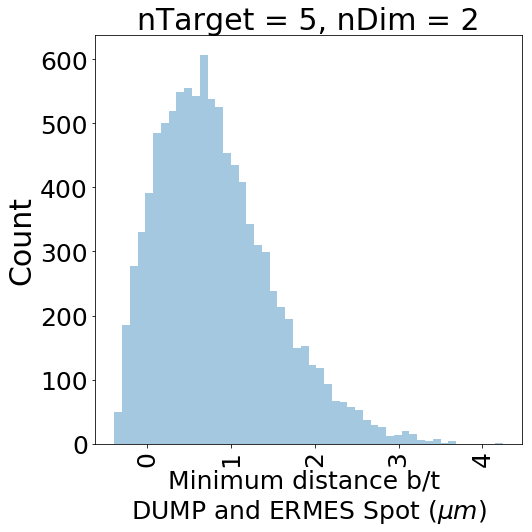

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


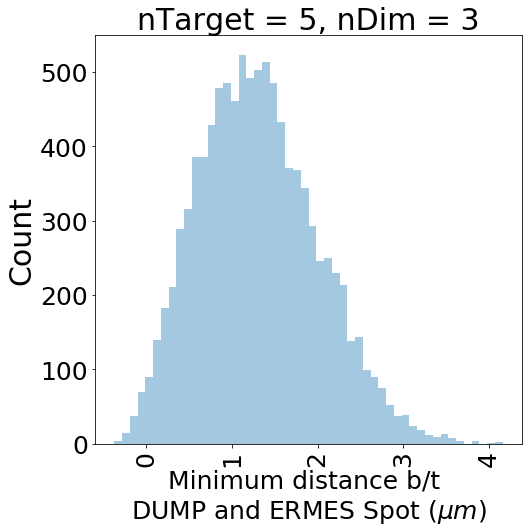

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


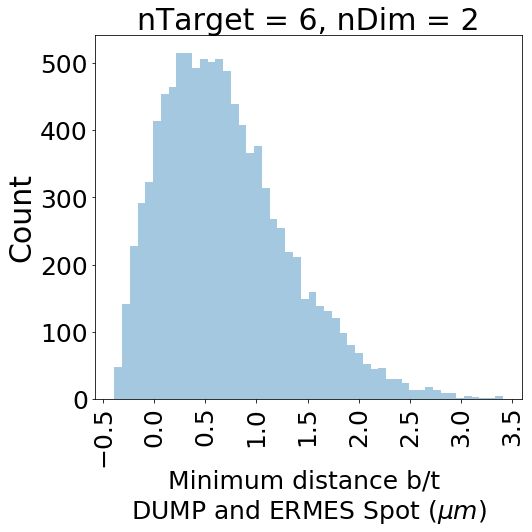

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


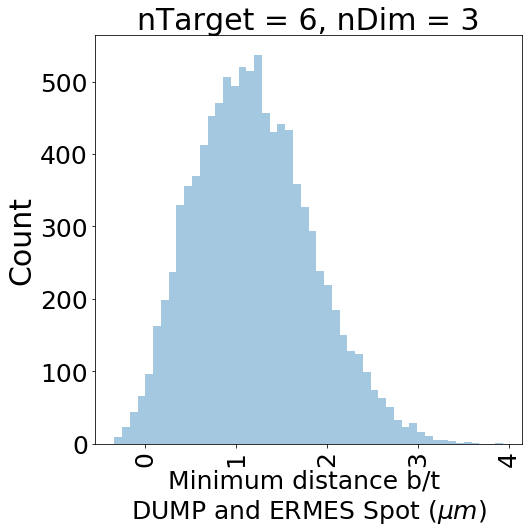

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


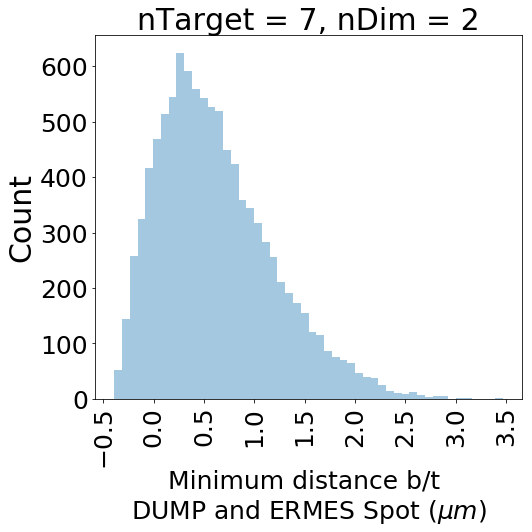

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


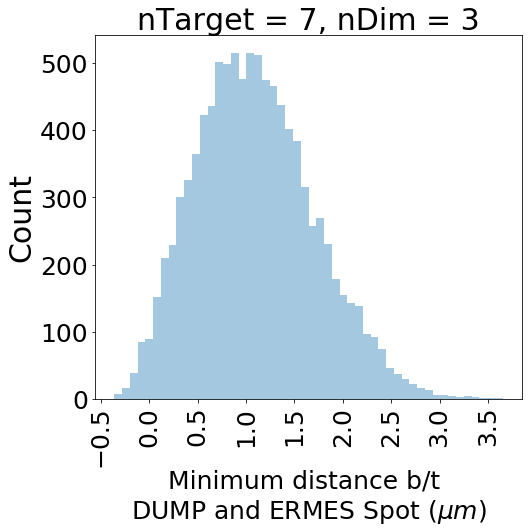

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


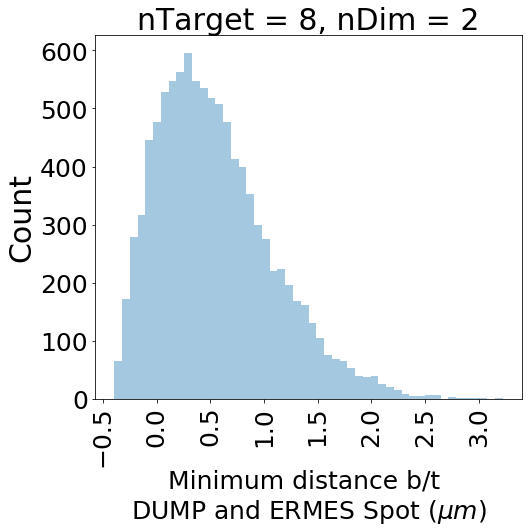

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


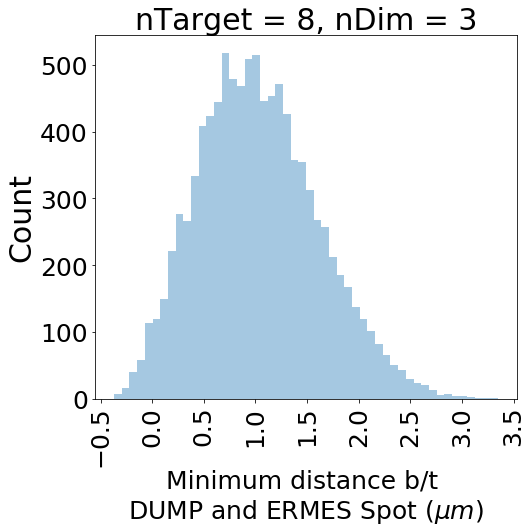

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


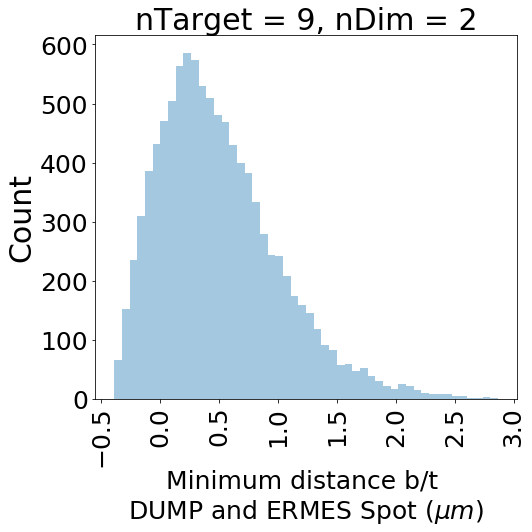

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


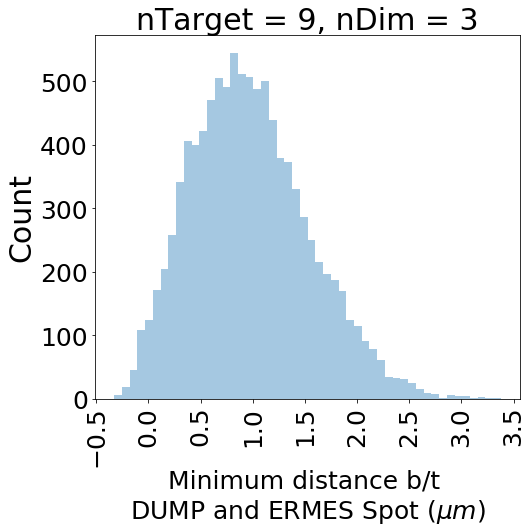

In [229]:
def plotMinPerSim(data_Filepath, ntarget, ndim):
    dataset = pd.read_csv(data_Filepath, header=None, names=['simNum', 'minDist'])
    plt.figure(figsize = (7.5,7.5))
    sns.distplot(dataset['minDist'], kde=False, norm_hist=False);
    plt.xticks(fontsize = 25, rotation = 90)
    plt.yticks(fontsize = 25)
    plt.ylabel('Count', fontsize = 30)
    plt.xlabel('Minimum distance b/t \nDUMP and ERMES Spot ($\mu m$)', fontsize = 25)
    plt.title(f'nTarget = {ntarget}, nDim = {ndim}', fontsize = 30)
    
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
for nTarg in NUMTARGETS:
    for dimI in [2,3]:
        plotMinPerSim(f"ntargets_{nTarg}_dim{dimI}.csv", nTarg, dimI)
        plt.savefig(f"ntargets_{nTarg}_dim{dimI}.eps", format='eps')
    

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


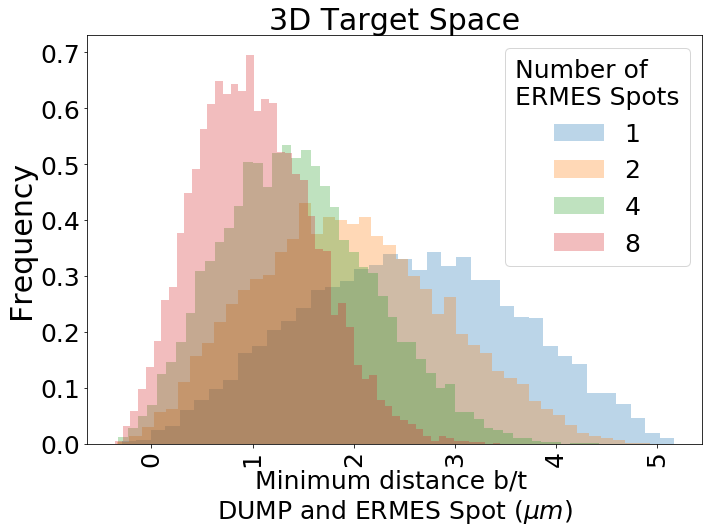

In [282]:
dataset = pd.read_csv("output_dim3.csv", header=None, names=['simNum', 'ntarget','minDist'])
plt.figure(figsize = (10,7.5))
sns.distplot(dataset[dataset["ntarget"] == 1]['minDist'], kde=False, norm_hist=True,hist=True,label="1", hist_kws=dict(alpha=0.3))
sns.distplot(dataset[dataset["ntarget"] == 2]['minDist'], kde=False, norm_hist=True,hist=True,label="2", hist_kws=dict(alpha=0.3))
sns.distplot(dataset[dataset["ntarget"] == 4]['minDist'], kde=False, norm_hist=True,hist=True,label="4", hist_kws=dict(alpha=0.3))
# sns.distplot(dataset[dataset["ntarget"] == 9]['minDist'], kde=False, norm_hist=True,hist=True,label="9")
sns.distplot(dataset[dataset["ntarget"] == 8]['minDist'], kde=False, norm_hist=True,hist=True,label="8", hist_kws=dict(alpha=0.3))
# sns.distplot(dataset[dataset["ntarget"] == 7]['minDist'], kde=False, norm_hist=True,hist=True,label="7")
# sns.distplot(dataset[dataset["ntarget"] == 6]['minDist'], kde=False, norm_hist=True,hist=True,label="6")
# sns.distplot(dataset[dataset["ntarget"] == 5]['minDist'], kde=False, norm_hist=True,hist=True,label="5")

# sns.distplot(dataset[dataset["ntarget"] == 3]['minDist'], kde=False, norm_hist=True,hist=True,label="3")

plt.xticks(fontsize = 25, rotation = 90)
plt.yticks(fontsize = 25)
plt.ylabel('Frequency', fontsize = 30)
plt.xlabel('Minimum distance b/t \nDUMP and ERMES Spot ($\mu m$)', fontsize = 25)
plt.title('3D Target Space', fontsize = 30)
plt.setp(legend.get_title(),fontsize=25)
plt.legend(title="Number of \nERMES Spots",fontsize=25, fancybox=True, title_fontsize = 25)
plt.savefig("dim3.pdf", format='pdf')

/home/gsun/.virtualenvs/tf_gpu_cv2_py3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


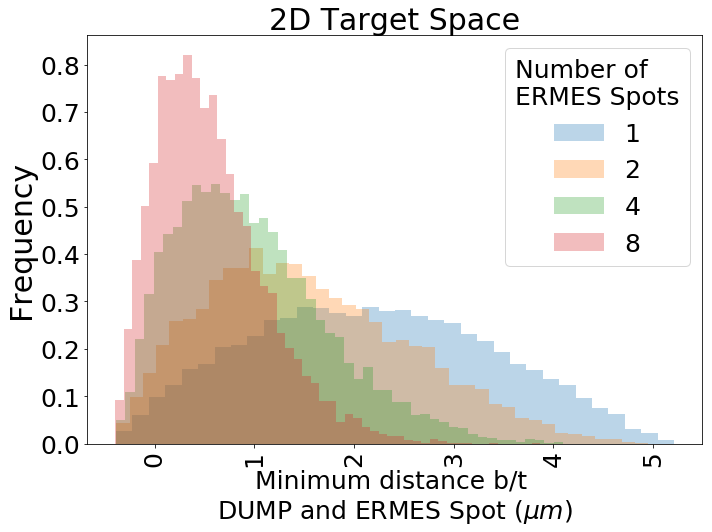

In [283]:
dataset = pd.read_csv("output_dim2.csv", header=None, names=['simNum', 'ntarget','minDist'])
plt.figure(figsize = (10,7.5))
sns.distplot(dataset[dataset["ntarget"] == 1]['minDist'], kde=False, norm_hist=True,hist=True,label="1", hist_kws=dict(alpha=0.3))
sns.distplot(dataset[dataset["ntarget"] == 2]['minDist'], kde=False, norm_hist=True,hist=True,label="2", hist_kws=dict(alpha=0.3))
sns.distplot(dataset[dataset["ntarget"] == 4]['minDist'], kde=False, norm_hist=True,hist=True,label="4", hist_kws=dict(alpha=0.3))
# sns.distplot(dataset[dataset["ntarget"] == 9]['minDist'], kde=False, norm_hist=True,hist=True,label="9")
sns.distplot(dataset[dataset["ntarget"] == 8]['minDist'], kde=False, norm_hist=True,hist=True,label="8", hist_kws=dict(alpha=0.3))
# sns.distplot(dataset[dataset["ntarget"] == 7]['minDist'], kde=False, norm_hist=True,hist=True,label="7")
# sns.distplot(dataset[dataset["ntarget"] == 6]['minDist'], kde=False, norm_hist=True,hist=True,label="6")
# sns.distplot(dataset[dataset["ntarget"] == 5]['minDist'], kde=False, norm_hist=True,hist=True,label="5")

# sns.distplot(dataset[dataset["ntarget"] == 3]['minDist'], kde=False, norm_hist=True,hist=True,label="3")

plt.xticks(fontsize = 25, rotation = 90)
plt.yticks(fontsize = 25)
plt.ylabel('Frequency', fontsize = 30)
plt.xlabel('Minimum distance b/t \nDUMP and ERMES Spot ($\mu m$)', fontsize = 25)
plt.title('2D Target Space', fontsize = 30)
plt.setp(legend.get_title(),fontsize=25)
plt.legend(title="Number of \nERMES Spots",fontsize=25, fancybox=True, title_fontsize = 25)
plt.savefig("dim2.pdf", format='pdf')